# Entorno y conexión

In [1]:
#Cargamos librerías clave y nos conectamos a la base SQLite.
import sqlite3, pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

DB_PATH = Path("C:/Users/jimen/Desktop/Rodrigo/Data scientist/mi_casino/database.sqlite")
conn = sqlite3.connect(DB_PATH)

# Transformación da datos

1. Carga y preparación de datos

In [2]:
# 1.1 Limpieza de fechas 

#Convertimos la columna `date` a `datetime`
def prep_dates(df, col="date"):
    df[col] = pd.to_datetime(df[col], errors="coerce")
    return df.dropna(subset=[col])

match   = prep_dates(pd.read_sql("SELECT * FROM Match", conn))
teams   = prep_dates(pd.read_sql("SELECT * FROM Team_Attributes", conn))
players = prep_dates(pd.read_sql("SELECT * FROM Player_Attributes", conn))

# 1.2 Selección de columnas esenciales
home_ids = [f"home_player_{i}" for i in range(1, 12)]
away_ids = [f"away_player_{i}" for i in range(1, 12)]

match = match[[
    "id","country_id","league_id","season","stage","date",
    "home_team_api_id","away_team_api_id",
    "home_team_goal","away_team_goal", *home_ids, *away_ids
]].query("home_team_goal <= 15 and away_team_goal <= 15")

2 · Ingeniería de características

In [3]:
# 2.1 Join táctico (último registro antes del partido)
teams = teams.sort_values(["team_api_id", "date"])
def add_team_feats(df, side):
    feats = ["buildUpPlaySpeed","buildUpPlayPassing",
             "chanceCreationPassing","chanceCreationCrossing",
             "chanceCreationShooting","defencePressure",
             "defenceAggression","defenceTeamWidth"]
    tmp = teams[["team_api_id","date",*feats]].copy()
    tmp.columns = ["team_api_id","t_date",* [f"{side}_{f}" for f in feats]]

    df = (df.merge(tmp, left_on=f"{side}_team_api_id", right_on="team_api_id", how="left")
            .query("t_date <= date")
            .sort_values(["id","t_date"])
            .drop_duplicates("id", keep="last")
            .drop(columns=["team_api_id","t_date"]))
    return df

match = add_team_feats(match,"home")
match = add_team_feats(match,"away")
print(match.columns)
match.head(5)

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11',
       'home_buildUpPlaySpeed', 'home_buildUpPlayPassing',
       'home_chanceCreationPassing', 'home_chanceCreationCrossing',
       'home_chanceCreationShooting', 'home_defencePressure',
       'home_defenceAggression', 'home_defenceTeamWidth',
       'away_buildUpPlaySpeed', 'away_buildUpPlayPassing',
       'away_chanceCreationPassing', 'away_chanceCreationCrossing',
       'away_chanceCreationShooting', 'away_defencePress

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,414,1,1,2009/2010,23,2010-02-24,9984,9986,1,0,...,60.0,70.0,40.0,50.0,45.0,43.0,60.0,70.0,70.0,70.0
5,421,1,1,2009/2010,24,2010-03-10,9986,9994,4,1,...,70.0,70.0,60.0,60.0,50.0,40.0,50.0,65.0,65.0,70.0
11,424,1,1,2009/2010,24,2010-02-24,9999,9987,1,1,...,70.0,70.0,45.0,45.0,50.0,35.0,60.0,70.0,65.0,70.0
17,434,1,1,2009/2010,26,2010-03-06,9986,8635,0,2,...,70.0,70.0,50.0,35.0,70.0,50.0,60.0,70.0,50.0,70.0
23,435,1,1,2009/2010,26,2010-03-06,9984,9994,4,0,...,60.0,70.0,60.0,60.0,50.0,40.0,50.0,65.0,65.0,70.0


In [4]:
# 2.2 Calidad media de jugadores y Δ rating
player_latest = (players.sort_values("date")
                        .drop_duplicates("player_api_id", keep="last")
                        .loc[:,["player_api_id","overall_rating"]])
rating_dict = dict(zip(player_latest["player_api_id"],
                       player_latest["overall_rating"]))

def rating_mean(ids):
    return np.nanmean([rating_dict.get(pid, np.nan) for pid in ids])

match["home_overall_rating_mean"] = match[home_ids].apply(rating_mean, axis=1)
match["away_overall_rating_mean"] = match[away_ids].apply(rating_mean, axis=1)
match["delta_rating"] = match["home_overall_rating_mean"] - match["away_overall_rating_mean"]

match.head(5)

,id,country_id,league_id,season,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,home_overall_rating_mean,away_overall_rating_mean,delta_rating
0,414,1,1,2009/2010,23,2010-02-24,9984,9986,1,0,...,50.0,45.0,43.0,60.0,70.0,70.0,70.0,63.454545,66.666667,-3.212121
5,421,1,1,2009/2010,24,2010-03-10,9986,9994,4,1,...,60.0,50.0,40.0,50.0,65.0,65.0,70.0,65.800000,65.000000,0.800000
11,424,1,1,2009/2010,24,2010-02-24,9999,9987,1,1,...,45.0,50.0,35.0,60.0,70.0,65.0,70.0,63.200000,70.909091,-7.709091
17,434,1,1,2009/2010,26,2010-03-06,9986,8635,0,2,...,35.0,70.0,50.0,60.0,70.0,50.0,70.0,66.333333,73.636364,-7.303030
23,435,1,1,2009/2010,26,2010-03-06,9984,9994,4,0,...,60.0,50.0,40.0,50.0,65.0,65.0,70.0,62.909091,66.272727,-3.363636


# 3 · Exploración visual (EDA)

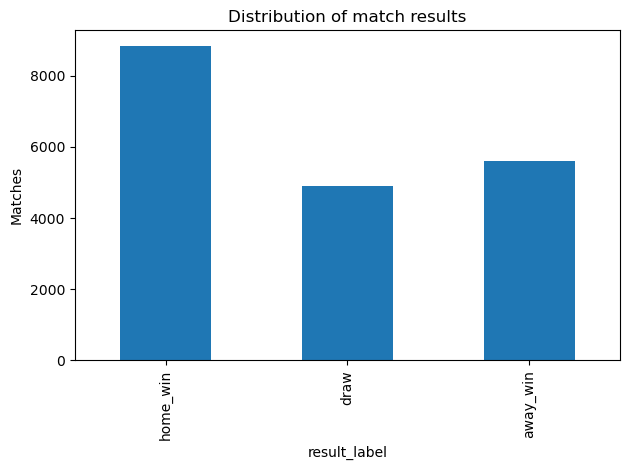

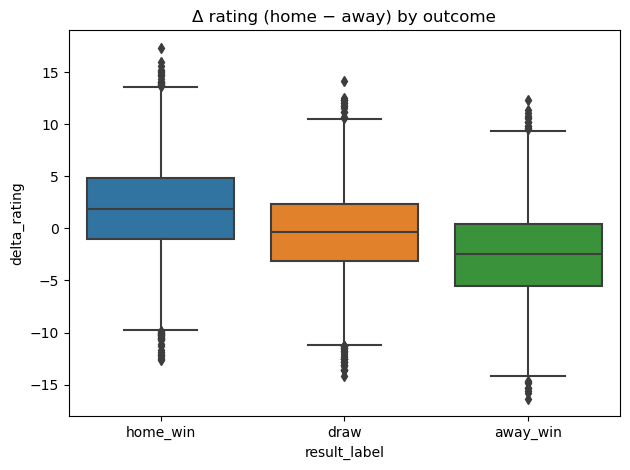

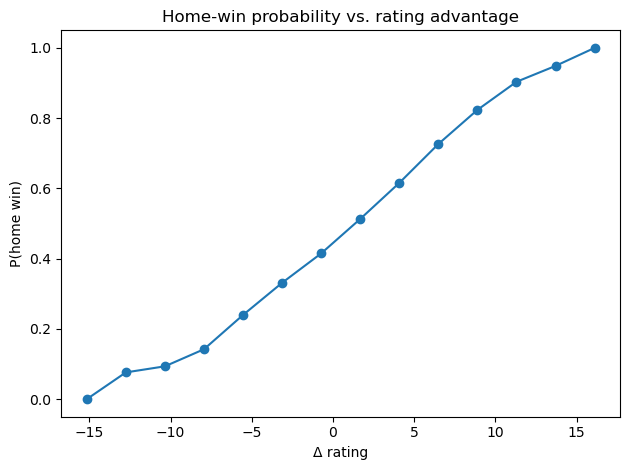

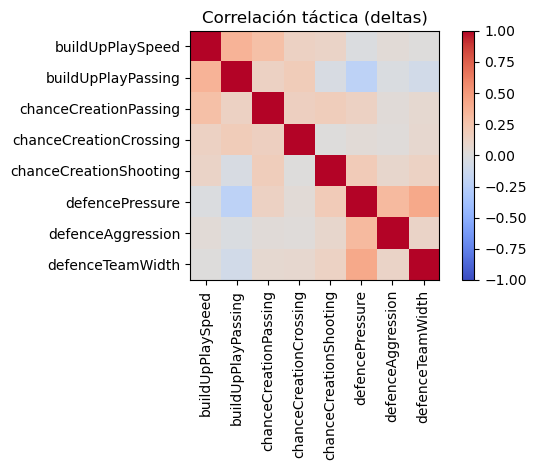

In [5]:
# 3.1 Distribución de resultados
match["result_label"] = match.apply(
    lambda r: "home_win" if r.home_team_goal > r.away_team_goal
              else ("away_win" if r.home_team_goal < r.away_team_goal else "draw"), axis=1)
match["result_label"].value_counts().reindex(["home_win","draw","away_win"]).plot(kind="bar")
plt.ylabel("Matches"); plt.title("Distribution of match results"); plt.tight_layout(); plt.show()

# 3.2 Box-plot Δ rating
sns.boxplot(data=match, x="result_label", y="delta_rating",
            order=["home_win","draw","away_win"])
plt.title("Δ rating (home − away) by outcome"); plt.tight_layout(); plt.show()

# 3.3 Probabilidad de victoria vs. Δ rating
bins = np.linspace(match.delta_rating.min(), match.delta_rating.max(), 15)
match["dr_bin"] = pd.cut(match.delta_rating, bins=bins, include_lowest=True)
prob = match.groupby("dr_bin")["result_label"].apply(lambda s: (s=="home_win").mean())
plt.plot([i.mid for i in prob.index], prob.values, marker="o")
plt.xlabel("Δ rating"); plt.ylabel("P(home win)")
plt.title("Home-win probability vs. rating advantage"); plt.tight_layout(); plt.show()

# 3.4 Heatmap correlación táctica
metrics = ["buildUpPlaySpeed","buildUpPlayPassing",
           "chanceCreationPassing","chanceCreationCrossing",
           "chanceCreationShooting","defencePressure",
           "defenceAggression","defenceTeamWidth"]
for m in metrics:
    match[f"delta_{m}"] = match[f"home_{m}"] - match[f"away_{m}"]
corr = match[[f"delta_{m}" for m in metrics]].corr()
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(); plt.title("Correlación táctica (deltas)")
plt.xticks(range(len(metrics)), metrics, rotation=90)
plt.yticks(range(len(metrics)), metrics); plt.tight_layout(); plt.show()

# 4 · Modelado

              precision    recall  f1-score   support

    away_win       0.46      0.58      0.51      1123
        draw       0.30      0.24      0.27       981
    home_win       0.62      0.58      0.60      1767

    accuracy                           0.49      3871
   macro avg       0.46      0.47      0.46      3871
weighted avg       0.49      0.49      0.49      3871

[[ 648  215  260]
 [ 370  238  373]
 [ 390  352 1025]]


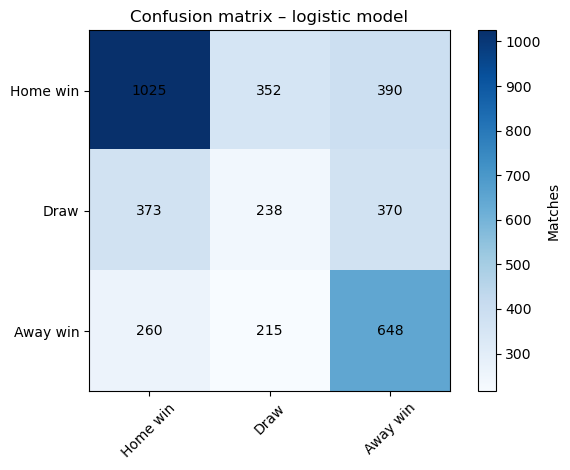

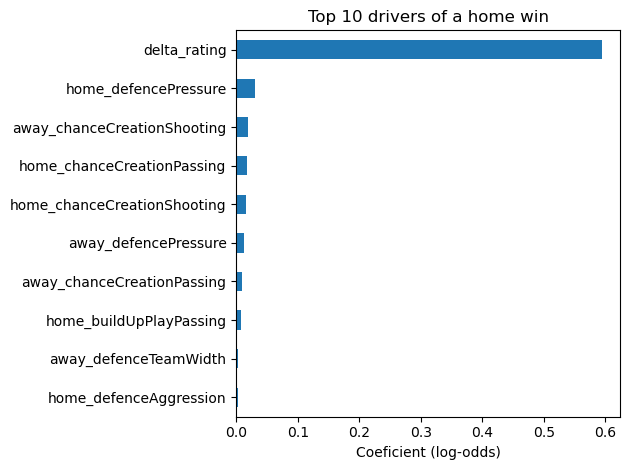

In [6]:
tactic_cols = [c for c in match.columns if c.startswith(("home_","away_"))
               and c.endswith(("Speed","Passing","Crossing",
                               "Shooting","Pressure",
                               "Aggression","TeamWidth"))]
feature_cols = tactic_cols + ["delta_rating"]

X_train, X_test, y_train, y_test = train_test_split(
    match[feature_cols], match["result_label"],
    test_size=0.2, stratify=match["result_label"], random_state=42)

pipe_bal = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="lbfgs",
        max_iter=500, class_weight="balanced", n_jobs=-1))
])
pipe_bal.fit(X_train, y_train)

print(classification_report(y_test, pipe_bal.predict(X_test)))
print(confusion_matrix(y_test, pipe_bal.predict(X_test)))

# Matriz de confusión visual
cm = confusion_matrix(y_test, pipe_bal.predict(X_test),
                      labels=["home_win","draw","away_win"])
plt.imshow(cm, cmap="Blues"); plt.colorbar(label="Matches")
plt.xticks(range(3), ["Home win","Draw","Away win"], rotation=45)
plt.yticks(range(3), ["Home win","Draw","Away win"])
for i in range(3):
    for j in range(3):
        plt.text(j,i,cm[i,j], ha="center", va="center")
plt.title("Confusion matrix – logistic model"); plt.tight_layout(); plt.show()

# 4.1 Coeficientes principales
import pandas as pd
coef_df = pd.DataFrame(pipe_bal.named_steps["clf"].coef_.T,
                       index=feature_cols,
                       columns=pipe_bal.named_steps["clf"].classes_)
coef_df["home_win"].sort_values(ascending=False).head(10).plot(kind="barh")
plt.gca().invert_yaxis(); plt.xlabel("Coeficient (log-odds)")
plt.title("Top 10 drivers of a home win"); plt.tight_layout(); plt.show()